# Apply parameters shift rules to train our variational quantum circuit using [TorchQuantum](https://github.com/mit-han-lab/torchquantum).
<p align="left">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/torchquantum_logo.jpg?raw=true" alt="torchquantum Logo" width="250">
</p>

Tutorial Author: Zirui Li, Hanrui Wang


###Outline
1. Introduction to Parameters Shift Rules.
2. Build the model and define the function.
3. Train the model.



##Introduction to Parameters Shift Rules

In this tutorial, you can learn parameters shift rules and how to use parameters shift rules to calculate gradients and use the gradient to train the model.

###Back Propagation

Previously, our quantum model was based on qiskit and pytorch. Once we did an inference of the model, pytorch will automatically build a computaion graph. We can calculate the gradients of each node in the computational graph in a reversed order based on the chain rule. This is called back propagation.
<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/bp.png?raw=true" alt="conv-full-layer" width="300">
</div>

###Parameters Shift Rules

As we all know, when executing a quantum circuit on real quantum machine, we can not observe the quantum state, so we can not use back propagation to calculate gradients when our circuits run on real quantum machine. Parameters shift rules offer us a technique to calculate gradients only by doing inference. For a circuit function $f(\theta)$, we can calculate $f'(\theta)$ by shifting $\theta$ twice and minus one result by the other and multiply with a factor. The figure below describes the workflow of how to calculate the gradient of a parameter in a 4-qubit circuit.

<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/ps.png?raw=true" alt="conv-full-layer" width="600">
</div>

Suppose an $m$-qubit quantum circuit is parametrized by $n$ parameters $\theta=[\theta_1,\cdots,\theta_i,\cdots,\theta_n]$, the expectation value of measurements of this circuit can be represented by a circuit function,
$$f(\theta)=\langle\psi|U(\theta_i)^{\dagger}\widehat{Q}U(\theta_i)|\psi\rangle, \quad f(\theta)\in\mathbb{R}^{m}, \theta\in\mathbb{R}^n.
$$
where $\theta_i$ is the scalar parameter whose gradient is to be calculated, and $U(\theta_i)$ is the gate where $\theta_i$ lies in. 

Here, for notation simplicity, we have already absorbed the unitaries before $U(\theta_i)$ into $\langle\psi|$, $|\psi\rangle$.
Unitaries after $U(\theta_i)$ and observables are fused into $\widehat{Q}$.

Usually, the rotation gates used in QNN can be written in the form $U(\theta_i)=e^{-\frac{i}{2}\theta_i H}$. Here $H$ is the Hermitian generator of $U$ with only 2 unique eigenvalues +1 and -1.

In this way, the gradients of the circuit function $f$ with respect to $\theta_i$ are,
$$    \begin{aligned}
    &\frac{\partial f(\theta)}{\partial \theta_i}=\frac{1}{2}\Big(f\big(\theta_+\big)-f\big(\theta_{-}\big)\Big), \\ &\theta_+=[\theta_1,\cdots,\theta_i+\frac{\pi}{2},\cdots,\theta_n], \theta_{-}=[\theta_1,\cdots,\theta_i-\frac{\pi}{2},\cdots,\theta_n],
    \end{aligned}
$$
where $\theta_+$ and $\theta_{-}$ are the **positive shift** and **negative shift** of $\theta$.

Note that this parameter shift rule is **fundamentally different** from any numerical difference methods that only approximate the directional derivatives.
Instead, the equation calculates the **exact** gradient w.r.t $\theta_i$ without any approximation errors or numerical issues. 

We apply $\text{softmax}$ on the expectation values of measurements $f(\theta)$ as the predicted probability for each class. 
Then we calculate the cross entropy between the predicted probability distribution $p$ and the target distribution $t$ as the classification loss $\mathcal{L}$, 
$$    \mathcal{L}(\theta)=-t^T\cdot\texttt{softmax}(f(\theta))=-\sum_{j=1}^m t_j \log{p_j},\quad p_j=\frac{e^{f_j(\theta)}}{\sum_{j=1}^m e^{f_j(\theta)}}.
$$

Then the gradient of the loss function with respect to $\theta_i$ is $\frac{\partial\mathcal{L}(\theta)}{\partial \theta_i}=\big(\frac{\partial\mathcal{L}(\theta)}{\partial f(\theta)}\big)^T\frac{\partial f(\theta)}{\partial \theta_i}$.

Here $\frac{\partial f(\theta)}{\partial \theta_i}$ can be calculated on real quantum circuit by the parameter shift rule, and $\frac{\partial\mathcal{L}(\theta)}{\partial f(\theta)}$ can be efficiently calculated on classical devices using backpropagation supported by automatic differentiation frameworks, e.g., PyTorch and TensorFlow.

Now we derive the parameter shift rule used in our QNN models.

Assume $U(\theta_i)=R_X(\theta_i),R_X(\alpha)=e^{-\frac{i}{2}\alpha X}$, where $X$ is the Pauli-X matrix.

Firstly, the RX gate is,
$$    \begin{aligned}
R_X(\alpha)&=e^{-\frac{i}{2}\alpha X}=\sum_{k=0}^{\infty}(-i\alpha/2)^kX^k/k!\\
&=\sum_{k=0}^{\infty}(-i\alpha/2)^{2k}X^{2k}/(2k)!+\sum_{k=0}^{\infty}(-i\alpha/2)^{2k+1}X^{2k+1}/(2k+1)!\\
&=\sum_{k=0}^{\infty}(-1)^k(\alpha/2)^{2k}I/(2k)!-i\sum_{k=0}^{\infty}(-1)^k(\alpha/2)^{2k+1}X/(2k+1)!\\
&=\cos(\alpha/2)I-i\sin(\alpha/2)X.
\end{aligned}
$$

Let $\alpha=\frac{\pi}{2}$, $R_X(\pm\frac{\pi}{2})=\frac{1}{\sqrt{2}}(I\mp iX)$.

As $f(\theta)=\langle\psi|R_X(\theta_i)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle$, $R_X(\alpha)R_X(\beta)=R_X(\alpha+\beta)$, and $\frac{\partial}{\partial \alpha}R_X(\alpha)=-\frac{i}{2}XR_X(\alpha)$,
we have
$$\begin{aligned}
\frac{\partial f(\theta)}{\partial \theta_i}
% &=\langle\psi|\frac{\partial}{\partial \theta_i}R_X(\theta_i)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle+\langle\psi|R_X(\theta_i)^{\dag}\widehat{Q}\frac{\partial}{\partial \theta_i}R_X(\theta_i)|\psi\rangle\\
=&\langle\psi|R_X(\theta_i)^{\dagger}(-\frac{i}{2}X)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle+\langle\psi|R_X(\theta_i)^{\dagger}\widehat{Q}(-\frac{i}{2}X)R_X(\theta_i)|\psi\rangle\\
% &=\frac{1}{2}(\langle\psi|R_X(\theta_i)^{\dagger}(-iX)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle+\langle\psi|R_X(\theta_i)^{\dagger}\widehat{Q}(-iX)R_X(\theta_i)|\psi\rangle)\\
=&\frac{1}{4}(\langle\psi|R_X(\theta_i)^{\dagger}(I-iX)^{\dagger}\widehat{Q}(I-iX)R_X(\theta_i)|\psi\rangle\\&-\langle\psi|R_X(\theta_i)^{\dagger}(I+iX)^{\dagger}\widehat{Q}(I+iX)R_X(\theta_i)|\psi\rangle)\\
=&\frac{1}{2}(\langle\psi|R_X(\theta_i)^{\dagger}R_X(\frac{\pi}{2})^{\dagger}\widehat{Q}R_X(\frac{\pi}{2})R_X(\theta_i)|\psi\rangle\\&-\langle\psi|R_X(\theta_i)^{\dagger}R_X(-\frac{\pi}{2})^{\dagger}\widehat{Q}R_X(-\frac{\pi}{2})R_X(\theta_i)|\psi\rangle)\\
=&\frac{1}{2}(f(\theta_+)-f(\theta_-)).
\end{aligned}
$$

Without loss of generality, the derivation holds for all unitaries of the form $e^{-\frac{i}{2}\alpha H}$, e.g., RX, RY, RZ, XX, YY, ZZ, where $H$ is a Hermitian matrix with only 2 unique eigenvalues +1 and -1.


##Build the model and define the function.

###Installation
Firstly, install qiskit.

In [ ]:
!pip install qiskit==0.32.1

     |████████████████████████████████| 6.1 MB 5.5 MB/s 
     |████████████████████████████████| 17.9 MB 401 kB/s 
     |████████████████████████████████| 237 kB 54.4 MB/s 
     |████████████████████████████████| 207 kB 69.9 MB/s 
     |████████████████████████████████| 2.1 MB 20.6 MB/s 
     |████████████████████████████████| 634 kB 59.1 MB/s 
     |████████████████████████████████| 1.6 MB 67.7 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
     |████████████████████████████████| 943 kB 28.9 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 37.5 MB 212 kB/s 
     |████████████████████████████████| 3.6 MB 45.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 6.4 MB 60.7 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.1-py3-none-any.whl size=11777 sha256=20729abb253db6a49cd65f7400bc567eb828a191abf7bc2599552774bb3a99fc
  Stored in directory: /root/.cache/pip/whee

Download and cd to the repo.

In [ ]:
!git clone https://github.com/mit-han-lab/torchquantum.git

Cloning into 'torchquantum'...
remote: Enumerating objects: 10813, done.
remote: Counting objects: 100% (7605/7605), done.
remote: Compressing objects: 100% (3836/3836), done.
remote: Total 10813 (delta 3803), reused 7127 (delta 3360), pack-reused 3208
Receiving objects: 100% (10813/10813), 3.29 MiB | 2.53 MiB/s, done.
Resolving deltas: 100% (5770/5770), done.


In [ ]:
%cd torchquantum

/content/torchquantum


Install torch-quantum.

In [ ]:
!pip install --editable .

Obtaining file:///content/torchquantum
     |████████████████████████████████| 11.2 MB 6.6 MB/s 
     |████████████████████████████████| 81 kB 13.6 MB/s 
     |████████████████████████████████| 895 kB 72.2 MB/s 
     |████████████████████████████████| 65 kB 5.1 MB/s 
     |████████████████████████████████| 296 kB 72.4 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Running setup.py develop for torchquantum
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Change PYTHONPATH and install other packages.

In [ ]:
%env PYTHONPATH=.

env: PYTHONPATH=.


Run the following code to store a qiskit token. You can replace it with your own token from your IBMQ account if you like.



In [ ]:
from qiskit import IBMQ
IBMQ.save_account('0238b0afc0dc515fe7987b02706791d1719cb89b68befedc125eded0607e6e9e9f26d3eed482f66fdc45fdfceca3aab2edb9519d96b39e9c78040194b86e7858', overwrite=True)

In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 4.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchquantum 0.1.0 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!ls artifact

aerbackend.py  example2  example4  example6  README.md
example1       example3  example5  example7


In [ ]:
!cp artifact/aerbackend.py ../../usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/backends/ -r

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import torchquantum as tq
import torchquantum.functional as tqf
from torchquantum.layers import SethLayer0

from torchquantum.datasets import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR




run python fix_qiskit_parameterization.py to fix it!


### Build a quantum model
Our 4-qubit quantum model consists of an encoder that can encode a 4x4 image to quantum state; a quantum layer RZZ+RY+RZZ+RY, 16 parameters in total; and PauliZ measure on each qubit.

In [ ]:
class QFCModel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            tq.encoder_op_list_name_dict['4x4_ryzxy'])

        # self.q_layer = tq.RandomLayer(n_ops=30, wires=list(range(self.n_wires)))
        self.arch = {'n_wires': self.n_wires, 'n_blocks': 2, 'n_layers_per_block': 2}
        self.q_layer = SethLayer0(self.arch)

        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 16)

        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(self.q_device, x)
            self.q_layer(self.q_device)
            x = self.measure(self.q_device)

        x = x.reshape(bsz, 4)

        return x

### Define the function about parameters shift rules

The function can shift the parameters and calculate the gradients to the PauliZ measurement result for each parameter. It returns both the PauliZ measurement result and the gradients for each parameter. 

In [ ]:
def shift_and_run(model, inputs):
    grad_list = []
    for i, param in enumerate(model.q_layer.parameters()):
        param.copy_(param + np.pi * 0.5)
        out1 = model(inputs)
        param.copy_(param - np.pi)
        out2 = model(inputs)
        param.copy_(param + np.pi * 0.5)
        grad = 0.5 * (out1 - out2)
        grad_list.append(grad)
    return model(inputs), grad_list

Set whether using gpu, using cuda, number of epochs, optimizer and scheduler. Initialize the model and the MNIST-36 classification dataset.

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = QFCModel().to(device)
n_epochs = 15
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=[3, 6],
    n_test_samples=3000,
    n_train_samples=5000
)

dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=256,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

[2022-02-22 15:56:39.069] Only use the front 5000 images as TRAIN set.
[2022-02-22 15:56:39.126] Only use the front 3000 images as TEST set.


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###Train the model.

During each training step, we calculated the gradients twice. First we use back propagation and second we use parameters shift rules.

In [ ]:
grads_bp = []
grads_ps = []

def train_params_shift(dataflow, model, device, optimizer):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)

        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs)
        outputs.requires_grad=True
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        for i, param in enumerate(model.q_layer.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')

def train_and_return_grad(dataflow, model, device, optimizer):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)
        
        # calculate gradients via back propagation
        outputs = model(inputs)
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        grad_bp = []
        for i, param in enumerate(model.q_layer.parameters()):
            grad_bp.append(param.grad.item())

        # calculate gradients via parameters shift rules
        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs)
        outputs.requires_grad=True
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        grad_ps = []
        for i, param in enumerate(model.q_layer.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
            grad_ps.append(param.grad.item())

        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')
        grads_bp.append(grad_bp)
        grads_ps.append(grad_ps)

def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['digit'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)
            prediction = F.log_softmax(outputs.reshape(-1, 2, 2).sum(-1).squeeze(), dim=1)

            target_all.append(targets)
            output_all.append(prediction)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train_and_return_grad(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])
    # valid
    valid_test(dataflow, 'valid', model, device)
    scheduler.step()

# test
valid_test(dataflow, 'test', model, device, qiskit=False)

Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.0032725424859373835
valid set accuracy: 0.6605809128630705
valid set loss: 0.6341466307640076
Epoch 2:
0.0037500000000000202
valid set accuracy: 0.7012448132780082
valid set loss: 0.6088106036186218
Epoch 3:
0.004172826515897166
valid set accuracy: 0.7460580912863071
valid set loss: 0.5812259316444397
Epoch 4:
0.00452254248593739
valid set accuracy: 0.7842323651452282
valid set loss: 0.5559991002082825
Epoch 5:
0.004783863644106527
valid set accuracy: 0.7941908713692946
valid set loss: 0.5379774570465088
Epoch 6:
0.004945369001834539
valid set accuracy: 0.7950207468879668
valid set loss: 0.5261160135269165
Epoch 7:
0.005000000000000025
valid set accuracy: 0.7966804979253111
valid set loss: 0.5185419321060181
Epoch 8:
0.00494536900183454
valid set accuracy: 0.7975103734439835
valid set loss: 0.5135748982429504
Epoch 9:
0.004783863644106529
valid set accuracy: 0.8
valid set loss: 0.5101684331893921
Epoch 10:
0.004522542485937393
valid set accuracy: 0.7983402489626557
valid set loss: 0.

### Plot and compare the gradients

We have recorded two sets of gradients calculated by back propagation and parameters shift rules respectively. Now we plot these gradients and we can valid that the gradients calculated by parameters shift rules are exactly the same with those calculated by back propagation. 

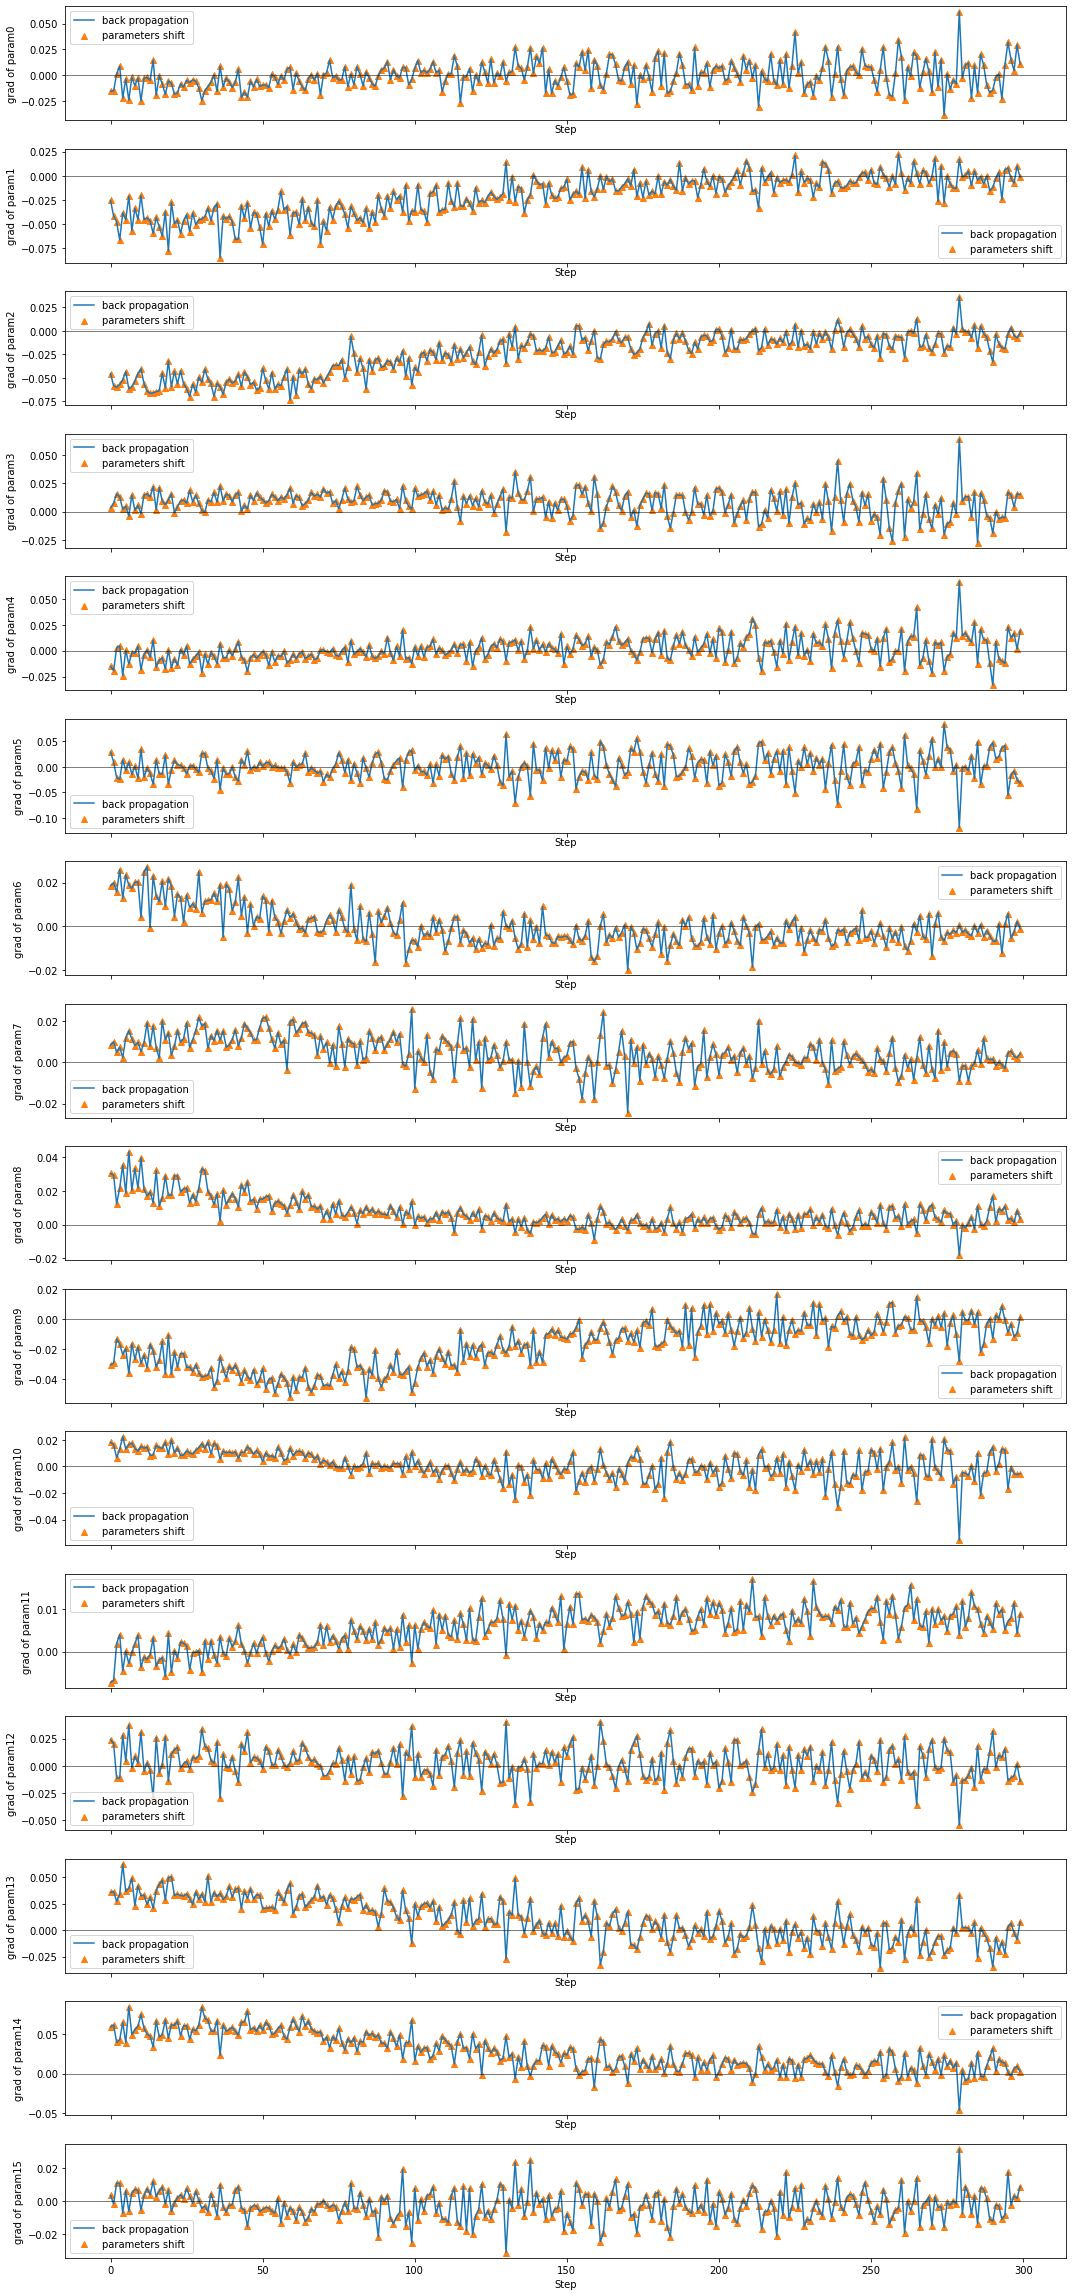

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

grads_bp = np.array(grads_bp)
grads_ps = np.array(grads_ps)

n_steps = grads_bp.shape[0]
n_params = grads_bp.shape[1]

fig, ax_list = plt.subplots(n_params, 1, sharex=True, figsize=(15, 2 * n_params))

for i, ax in enumerate(ax_list):
  ax.plot(grads_bp[:, i], c="#1f77b4", label="back propagation")
  ax.scatter(range(n_steps), grads_ps[:, i], c="#ff7f0e", marker="^", label="parameters shift")
  ax.set_ylabel("grad of param{0}".format(i))
  ax.set_xlabel("Step")
  ax.legend()
  ax.axhline(color='black', lw=0.5)

plt.tight_layout()
plt.show()


## A simple 2 qubit model for simple 2 classification task

In [ ]:
class Q2Model(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 2
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder([{'input_idx': [0], 'func': 'ry', 'wires': [0]}])

        self.arch = {'n_wires': self.n_wires, 'n_blocks': 1, 'n_layers_per_block': 2}
        self.ansatz = SethLayer0(self.arch)

        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        data = 2 * torch.arcsin(torch.sqrt(x[:, 0] + x[:, 1] - 2 * x[:, 0] * x[:, 1])).reshape(bsz, 1)

        if use_qiskit:
            data = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.ansatz, self.measure, data)
        else:
            self.encoder(self.q_device, data)
            self.ansatz(self.q_device)
            data = self.measure(self.q_device)

        data = data.reshape(bsz, 2)

        return data



Load the dataset.

In [ ]:
from torchquantum.datasets import Simple2Cls

dataset = Simple2Class()
dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

Define train and valid function. The model is a 2-qubit model so there is a slightly difference to the process of the circuit output.

In [ ]:
def train_2qubit(dataflow, model, device, optimizer, input_name = 'image', target_name = 'digit'):
    for feed_dict in dataflow['train']:
        inputs = feed_dict[input_name].to(device)
        targets = feed_dict[target_name].to(device)

        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs)
        outputs.requires_grad=True
        prediction = F.log_softmax(outputs, dim=1)
        loss = F.nll_loss(prediction, targets)
        optimizer.zero_grad()
        loss.backward()
        for i, param in enumerate(model.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test_2qubit(dataflow, split, model, device, qiskit=False, input_name = 'image', target_name = 'digit'):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict[input_name].to(device)
            targets = feed_dict[target_name].to(device)

            outputs = model(inputs, use_qiskit=qiskit)
            prediction = F.log_softmax(outputs, dim=1)

            target_all.append(targets)
            output_all.append(prediction)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")


Train and valid the model on ibmq_quito.

In [ ]:
model = Q2Model().to(device)
n_epochs = args.epochs
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train_2qubit(dataflow, model, device, optimizer, input_name='data', target_name='target')
    print(optimizer.param_groups[0]['lr'])
    # valid
    valid_test_2qubit(dataflow, 'valid', model, device, qiskit=False, input_name='data', target_name='target')
    scheduler.step()
# test
valid_test(dataflow, 'test', model, device, qiskit=False, input_name='data', target_name='target')
